In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
train_df = pd.read_csv('/content/labels.csv')
train_dir = '/content/drive/MyDrive/train'
test_dir = '/content/drive/MyDrive/test'

In [ ]:
lb = LabelBinarizer()
train_df['target'] = lb.fit_transform(train_df['breed']).tolist()

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
def load_images(df, folder, img_size=224):
    images = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(folder, row['id'] + '.jpg')
        img = cv2.imread(path)

        # Check if image is loaded properly
        if img is None:
            print(f"Warning: Unable to read image {path}")
            continue

        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        labels.append(row['target'])
    return np.array(images), np.array(labels)


In [ ]:

X, y = load_images(train_df, train_dir, IMG_SIZE)
X = preprocess_input(X)

 79%|███████▉  | 8121/10222 [02:53<06:41,  5.24it/s]

 85%|████████▍ | 8654/10222 [02:53<00:01, 910.06it/s]

 90%|████████▉ | 9158/10222 [02:53<00:00, 1581.52it/s]

 95%|█████████▌| 9714/10222 [02:54<00:00, 2120.08it/s]

100%|██████████| 10222/10222 [02:54<00:00, 58.64it/s] 


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(lb.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
model.fit(X, y, validation_split=0.1, epochs=5, batch_size=BATCH_SIZE, callbacks=[checkpoint])


Epoch 1/5
  6/229 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 8.6806e-04 - loss: 4.9617

KeyboardInterrupt: 

In [ ]:
test_files = os.listdir(test_dir)
X_test = []
ids = []


In [ ]:
for file in tqdm(test_files):
    path = os.path.join(test_dir, file)
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_test.append(img)
    ids.append(file.split('.')[0])

X_test = np.array(X_test)
X_test = preprocess_input(X_test)

100%|██████████| 4390/4390 [01:43<00:00, 42.60it/s] 


In [ ]:
preds = model.predict(X_test, batch_size=32)
pred_df = pd.DataFrame(preds, columns=lb.classes_)
pred_df.insert(0, 'id', ids)
pred_df.to_csv('submission.csv', index=False)

138/138 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step


In [ ]:
model.save('cnn_model.h5')


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
model.fit(X, y, validation_split=0.1, epochs=5, batch_size=32, callbacks=[checkpoint])


In [ ]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

train_df = pd.read_csv('/content/labels.csv')  # same CSV used during training
lb = LabelBinarizer()
lb.fit(train_df['breed'])             # to get class-to-breed mapping


LabelBinarizer()

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving white-cat-hisses.webp to white-cat-hisses.webp


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

def predict_dog_breed(image_path, img_size=224):
    img = cv2.imread('/content/white-cat-hisses.webp')
    if img is None:
        print("⚠️ Couldn't read the image!")
        return
    img_resized = cv2.resize(img, (img_size, img_size))
    img_input = preprocess_input(img_resized)
    img_input = np.expand_dims(img_input, axis=0)


    preds = model.predict(img_input)
    top_idx = np.argmax(preds[0])
    breed = lb.classes_[top_idx]
    confidence = preds[0][top_idx]


    print(f"✅ Predicted Breed: {breed}")
    print(f"📊 Confidence: {confidence * 100:.2f}%")

    if confidence < 0.3:
       print("⚠️ This might not be a dog or the image is unclear.")


    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"{breed} ({confidence * 100:.1f}%)")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
✅ Predicted Breed: chihuahua
📊 Confidence: 14.47%
⚠️ This might not be a dog or the image is unclear.


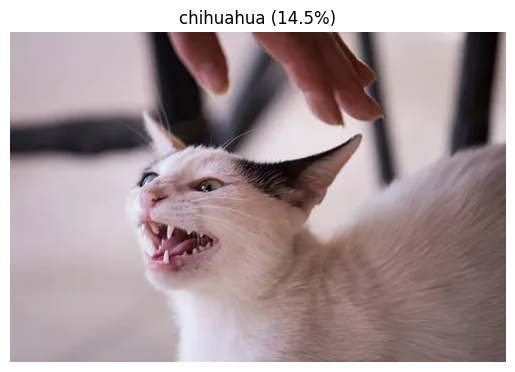

In [ ]:
predict_dog_breed('dog_photo.jpg')


In [ ]:
from google.colab import files
files.download('Major_Assignment_2.ipynb')


FileNotFoundError: Cannot find file: Major_Assignment_2.ipynb